In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import glob
import random
from transformers import pipeline
from PIL import Image
import numpy as np

In [2]:
# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

In [3]:
imgs = glob.glob("../pyronear_cam_data/**/*.jpg")
len(imgs)

0

In [4]:
import pandas as pd
ds_path = '../lidar/data/ds_eval_loc/'
metadata = pd.read_json(ds_path+'image_data.json', orient='index')
metadata.head()

/tmp/ipykernel_2246260/1501756085.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,cam,x,y,z,azimuth_degrees,pitch_degrees,lon,lat
axis-angel_2024_03_12T06_35_43.jpg,axis-angel,-46.06,0.00,1.0,180.000000,-1.243743,-115.57397,36.31894
axis-angel_2024_03_12T06_36_44.jpg,axis-angel,-25.08,-0.94,1.0,-177.853555,-2.281711,-115.57397,36.31894
axis-angel_2024_03_12T06_37_45.jpg,axis-angel,-25.08,-0.94,1.0,-177.853555,-2.281711,-115.57397,36.31894
axis-angel_2024_03_12T06_38_45.jpg,axis-angel,-25.08,-0.94,1.0,-177.853555,-2.281711,-115.57397,36.31894
axis-angel_2024_03_12T06_39_46.jpg,axis-angel,-25.08,-0.94,1.0,-177.853555,-2.281711,-115.57397,36.31894


In [25]:
img_name = 'axis-skydomenau_2024_03_12T07_48_54.jpg'
img_meta = metadata.loc[img_name]
print('lat:', img_meta['lat'], 'lon:', img_meta['lon'],'azimuth:', img_meta['azimuth_degrees'])

lat: 35.18057 lon: -111.65288 azimuth: 10.625085898338114


../lidar/data/pyronear_cam_data/brison_3/pyronear_brison_3_2023_10_07T15_26_41.jpg


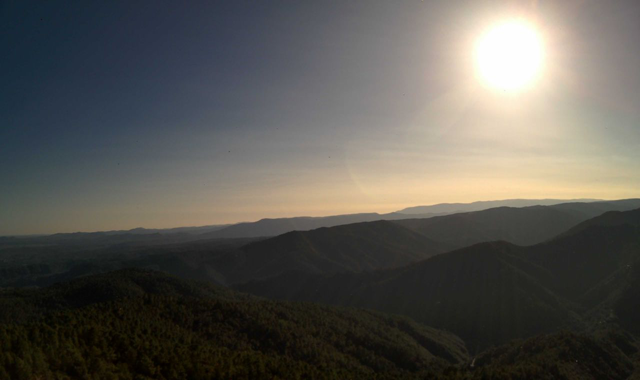

In [14]:
# Pick a random image
#file = random.choice(imgs)
file = '../lidar/data/pyronear_cam_data/brison_3/pyronear_brison_3_2023_10_07T15_26_41.jpg'#brison_4/pyronear_brison_4_2023_07_04T06_07_57.jpg'
#file = ds_path+'images/'+img_name
print(file)
# Compute depth using midas
img = Image.open(file)
img.resize((640,380))

In [15]:
# inference
depth = pipe(img)["depth"]

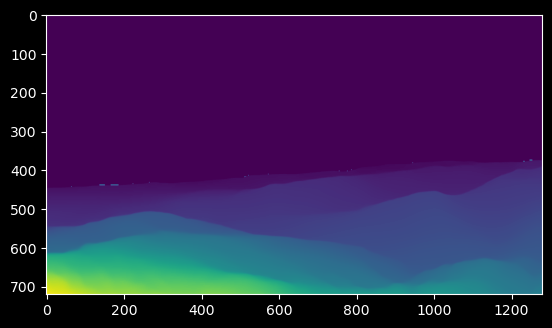

In [16]:
plt.imshow(np.array(depth))

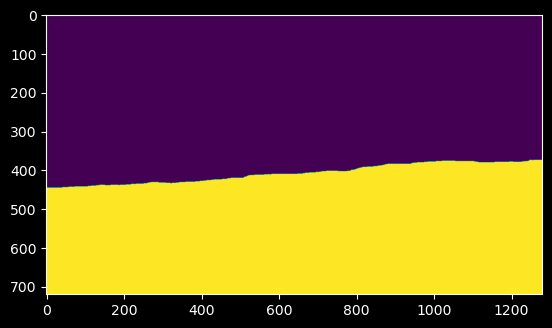

In [24]:
# Threshold depth 
th = 1
(T, res) = cv2.threshold(np.array(depth), th, 255, cv2.THRESH_BINARY)
plt.imshow(res)

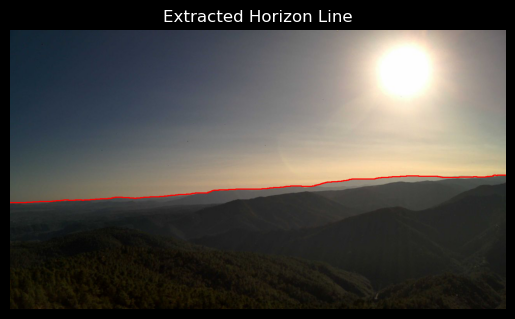

In [30]:
mask_image = res.astype("uint8")

# Threshold the image to make sure it's binary
_, binary_mask = cv2.threshold(mask_image, 127, 255, cv2.THRESH_BINARY)
# extract edges
edges = cv2.Canny(mask_image, 50, 100) 


# Find contours in the binary mask; the largest contour should correspond to the boundary between the sky and the land
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is the horizon line
# Sort the contours by area and get the largest one
#horizon_contour = max(contours, key=cv2.contourArea)
horizon_contour = np.empty((1,2), dtype='int32')

for c in contours:
    horizon_contour = np.append(horizon_contour, c.reshape(c.shape[0], -1), axis=0)
horizon_contour = np.delete(horizon_contour, [0], axis=0)
horizon_contour = horizon_contour[np.argsort(horizon_contour[:,0])]
horizon_contour = horizon_contour.reshape((horizon_contour.shape[0], 1,2))

# Draw the horizon contour directly on the color image
img_np = np.array(img)
img_line = cv2.polylines(img_np.astype("uint8"), [horizon_contour], False, (255, 0, 0), thickness=2)  # Red color for visibility

# Let's display the contour image
plt.imshow(img_line)
plt.title('Extracted Horizon Line')
plt.axis('off')
plt.show()


In [19]:
import numpy as np
# Export contour line
np.save('../lidar/data/horizon/horizon_contour_'+img_name.split('.')[0]+'.npy',horizon_contour)